In [118]:
!pip install  langgraph langchain langchain-community  python-dotenv
!pip install --upgrade langchain langchain_community transformers accelerate python-dotenv langgraph
!pip install --upgrade langchain_huggingface

In [119]:

from typing import TypedDict, Literal, Annotated
import operator
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langgraph.graph import StateGraph,START,END
import os
from dotenv import load_dotenv
from langchain_core.messages import SystemMessage,HumanMessage

os.environ['HUGGING_FACE_HUB_TOKEN'] = ''

In [120]:
generator_llm = HuggingFaceEndpoint(
    repo_id="google/flan-t5-small",
    task="text2text-generation",
    max_new_tokens=100,
    do_sample=False,
    temperature=0.1,
    timeout=60,
)
generator = ChatHuggingFace(llm=generator_llm)

In [121]:
evaluator_llm = HuggingFaceEndpoint(
    repo_id="facebook/bart-large-mnli",
    task="text-classification",
    timeout=60,
)

In [122]:
optimizer_llm = HuggingFaceEndpoint(
    repo_id="sshleifer/distilbart-cnn-12-6",
    task="summarization",
    max_new_tokens=120,
    do_sample=False,
    temperature=0.1,
    timeout=60,
)
optimizer = ChatHuggingFace(llm=optimizer_llm)

In [123]:
class State(TypedDict):
  Topic:str
  Essay:str
  Evaluation:Literal['Approved','Rejected']
  Feedback:str
  max_iteration: int
  iteration: int

  Eassy_history: Annotated[list[str], operator.add]
  feedback_history: Annotated[list[str], operator.add]

In [124]:
def Generator(state:State):
  Message=[
      SystemMessage(content="you are cleaver nerdy essay maker"),
      HumanMessage(content=f"""
Write a short, original, Essay on the topic: "{state['Topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]
  Essay=generator.invoke(Message).content
  return {'Essay':Essay}


In [132]:
from pydantic import BaseModel, Field
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate



class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

def Evaluator(state: State):
    parser = PydanticOutputParser(pydantic_object=TweetEvaluation)

    prompt = PromptTemplate(
        template="Answer the user query.\n{format_instructions}\n{query}",
        input_variables=["query"],
        partial_variables={"format_instructions": parser.get_format_instructions()},
    )

    messages = [
        SystemMessage(content="You are a strict but fair academic essay evaluator."),
        HumanMessage(content=prompt.format(query=f"""
Evaluate the following essay and provide your evaluation and feedback in a JSON object.

Essay:
{state['Essay']}

Use the criteria below to evaluate the essay:

1. Clarity – Is the argument clear, coherent, and logically structured?
2. Depth – Does the essay show critical thinking, analysis, and depth of understanding?
3. Evidence – Does it use relevant examples, references, or data to support claims?
4. Organization – Is the essay well-structured, with a strong introduction, body, and conclusion?
5. Writing quality – Is the grammar, vocabulary, and style appropriate for an academic essay?

Auto-reject if:
- The essay contains plagiarism or copied text
- The essay lacks structure (no clear intro, body, conclusion)
- The essay is underdeveloped (too short, vague, or superficial)
- The essay is incoherent or off-topic
"""))
    ]

    chain = evaluator_llm | parser


    evaluation_result = chain.invoke(messages)

    return {"Evaluation": evaluation_result.evaluation, "Feedback": evaluation_result.feedback, "feedback_history": [evaluation_result.feedback]}

In [126]:
def condition(state: State):
    if state["Evaluation"] == "approved" or state['iteration'] >= state['max_iteration']:
        return "Approved"
    else:
        return "Rejected"


In [127]:
def Optimizer(state:State):
  Message=[
      SystemMessage(content="you are cleaver nerdy essay maker remake essay by taking note from the feedback "),
              HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['Feedback']}"

Topic: "{state['Topic']}"
Original Tweet:
{state['Essay']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]

  iteration=state['iteration']+1
  es=generator.invoke(Message).content

  return {'Essay':es,'iteration':iteration,'Eassy_history':[es]}

In [128]:
Graph=StateGraph(State)
Graph.add_node('Gen',Generator)
Graph.add_node('Eval',Evaluator)
Graph.add_node('Opt',Optimizer)

Graph.add_edge(START,'Gen')
Graph.add_edge('Gen','Eval')
Graph.add_conditional_edges('Eval',condition, {'Approved':END,'Rejected':'Opt'})
Graph.add_edge('Opt','Eval')

In [133]:
workflow=Graph.compile()

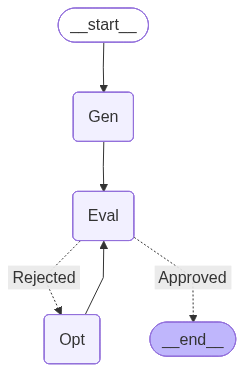

In [134]:
workflow

In [ ]:
initial_state = {
    "Topic": "War",
    "iteration": 1,
    "max_iteration": 5
}
result = workflow.invoke(initial_state)